# <center/> CS146: Assignment III
# <center/> Taha Bouhoun

You should submit your work as a Python notebook, or a Python notebook and PDF both if you want to separate your code and your report. (Please do not submit your Python code as a PDF only. This usually results in lines being truncated.)
Typeset your PDF using Google Docs, LaTeX, Jupyter notebooks, CoCalc, or any other software that allows you to type text and math. Make sure your code is readable and commented.

Show your work for all exercises! Do not simply turn in final answers

In [3]:
import numpy as np
from math import*
import scipy as sp
import random as rn
import pystan
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

# Implement models in Stan (required)
Implement each of the models below using Stan and produce the results or plots requested for
each model. You have seen each of these models before in class.
The goal of this exercise is to learn how to implement different types of parameters, likelihood
functions, and prior distributions using Stan. Stan always generates samples for estimating
posterior distributions, while we used conjugate distributions in class. Check that your results from
Stan’s samples match the results we computed in class.

## 1. Call center data set

Exponential likelihood with a gamma prior. Estimate the number of calls per minute for the 13th hour of the call center data set.

Results to compute:
    - Posterior 98% confidence interval over λ (check that it matches results in the solution notebook below).
    - Histogram of posterior λ samples.

*Resources for you to use:*
- Data set: call_center.csv
- Solution for class activity (call_center_solution.ipynb)

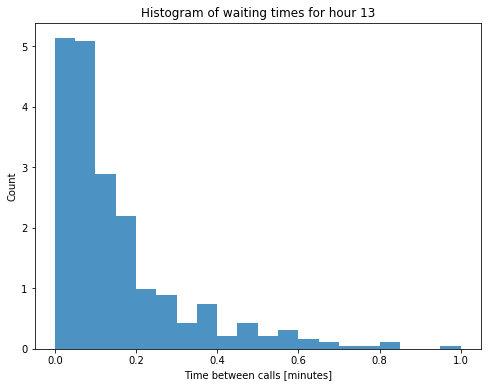

In [4]:
# Importing Call Center data
waiting_times_day = np.loadtxt('call_center.csv')

# Make 24 empty lists, one per hour
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

# Plotting the dsitribution of waiting time for the 13th hour 
hour_index = 13
waiting_times_hour = waiting_times_per_hour[hour_index]

plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20, alpha=0.8, density= True)
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Count')
plt.title(f'Histogram of waiting times for hour {hour_index}')
plt.show()

In [5]:
dataset = {
        'alpha': 1,     # Fixed prior hyperparameters for the
        'beta': 0.25,   # Gamma distribution
        'waiting_times': waiting_times_hour,  # waiting time data
        'l_size': len(waiting_times_hour)}

In [6]:
stan_code = """

data {
    int<lower=0> l_size;
    real<lower=0> waiting_times[l_size];
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

parameters {
    real<lower=0> lambda;  // The parameter of the exponential likelihood
}

model {
    lambda ~ gamma(alpha, beta);  // prior over λ
    for (i in 1:l_size){
        waiting_times[i] ~ exponential(lambda);} // likelihood function
    }

"""

In [7]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5a77ee2a3e09a93c2d4600e06f8032e1 NOW.


In [8]:
stan_results = stan_model.sampling(data = dataset)

In [9]:
print(stan_results.stansummary(pars=['lambda'], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_5a77ee2a3e09a93c2d4600e06f8032e1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

         mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
lambda   6.34  7.8e-3   0.32   5.73   6.34   6.99   1634    1.0

Samples were drawn using NUTS at Fri Oct 18 18:57:17 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Posterior 98% CI for lambda [Using Stan]:
 [5.6490839  7.12893158] 
Mean of the parameter lambda:  6.34430

Posterior 98% CI for lambda [Assignment II]:
 5.61912  |  7.12847 
Mean of the parameter lambda:  6.34942


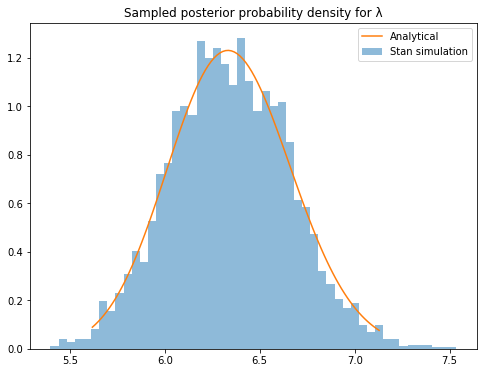

In [10]:
# Posterior from Stan simulation
posterior_samples = stan_results.extract()


# Posterior from assingment II
lambda_ = 1 / np.mean(waiting_times_hour)
dist = sts.expon(scale=1/lambda_)

post_α = dataset['alpha'] + len(waiting_times_hour)
post_β = dataset['beta'] + np.sum(waiting_times_hour)

posterior = sts.gamma(post_α, scale=1/post_β)
l_bond, u_bond = posterior.interval(0.98)
x = np.linspace(l_bond, u_bond, 100)
y = posterior.pdf(x)

plt.figure(figsize=(8, 6))
plt.hist(posterior_samples['lambda'], 
         bins=50, density=True, alpha=0.5, label='Stan simulation')
plt.plot(x, y, label='Analytical')
plt.title('Sampled posterior probability density for λ')
plt.legend(loc=1)

print(
    "Posterior 98% CI for lambda [Using Stan]:\n",
    np.percentile(posterior_samples['lambda'], [1, 99]),
    "\nMean of the parameter lambda: ",
    '{:.5f}'.format(np.mean(posterior_samples['lambda'])))

print(
    "\nPosterior 98% CI for lambda [Assignment II]:\n",
    '{:.5f}'.format(l_bond), " | ", '{:.5f}'.format(u_bond),
    "\nMean of the parameter lambda: ",
    '{:.5f}'.format(np.mean(posterior.mean())))
    
plt.show()

## 2. Normal likelihood with normal-inverse-gamma prior. 

Results to compute:
    - 95% posterior confidence intervals for the mean μ and variance σ of the data.
    - Take 10 samples from your posterior over μ and σ and plot the normal distributions corresponding to them.

*Resources for you to use:*
- Data and solution for class activity (normal_inverse_gamma_solution.ipynb)

In [11]:
# Importing data
data2 = np.loadtxt('data2.csv')
dataset2 = {
    'mu' : 0,        
    'nu' : 0.054,    
    'alpha' : 1.12,  
    'beta' : 0.4,
    'datum' : data2,
    'l_size' : len(data2),}

In [12]:
stan_code = """

data {
    int<lower=0> l_size;
    real datum[l_size];    
    real<lower=0> mu;
    real<lower=0> nu;
    real<lower=0> alpha;  
    real<lower=0> beta; 
}

parameters {
    real mu_mean;
    real<lower=0> sigma2;
}

model {
    mu_mean ~ normal(mu,sqrt(sigma2/nu)); 
    sigma2 ~ inv_gamma(alpha,beta); 
    for (i in 1: l_size){
        datum[i] ~ normal(mu_mean,sqrt(sigma2));}
    }
"""

In [13]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ee675a5a01de2f8a3143abed645f65b4 NOW.


In [14]:
stan_results = stan_model.sampling(data = dataset2)
print(stan_results.stansummary(pars=['mu_mean', 'sigma2'], probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_ee675a5a01de2f8a3143abed645f65b4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mu_mean   3.06  2.3e-3   0.13    2.8   3.06   3.32   3311    1.0
sigma2    3.61  6.4e-3   0.37   2.96   3.59   4.39   3287    1.0

Samples were drawn using NUTS at Fri Oct 18 18:58:27 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


95% CI for the mean: [2.79964005 3.32386322] 
Mean: 3.0582


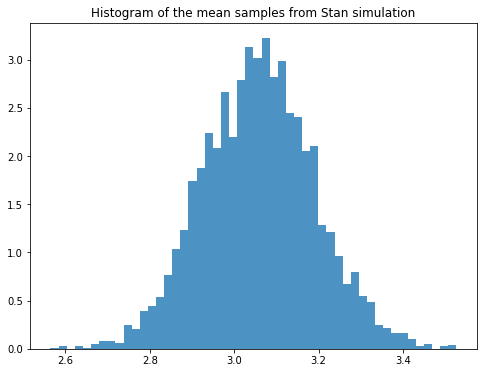


95% CI for the variance: [2.9635247  4.38986031] 
Mean: 3.6096


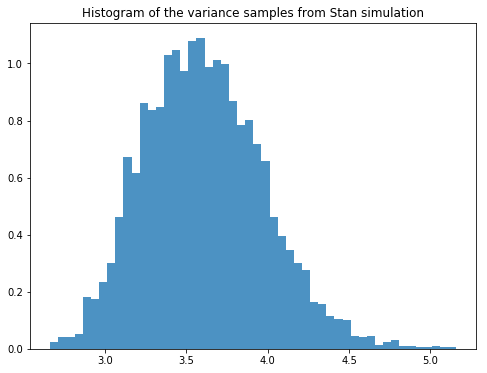

In [21]:
mu_samples = stan_results.extract()['mu_mean']
sigma2_samples = stan_results.extract()['sigma2'] 


print("95% CI for the mean:",
     np.percentile(mu_samples, [2.5, 97.5]),
     "\nMean:", '{:.4f}'.format(np.mean(mu_samples)))
plt.figure(figsize=(8, 6))
plt.hist(mu_samples, bins=50, density=True, alpha=0.8)
plt.title("Histogram of the mean samples from Stan simulation")
plt.show()

print("\n95% CI for the variance:",
     np.percentile(sigma2_samples, [2.5, 97.5]),
     "\nMean:", '{:.4f}'.format(np.mean(sigma2_samples)))
plt.figure(figsize=(8, 6))
plt.hist(sigma2_samples, bins=50, density=True, alpha=0.8)
plt.title("Histogram of the variance samples from Stan simulation")
plt.show()

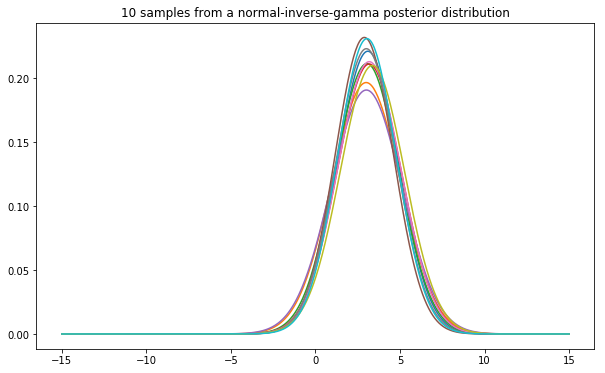

In [22]:
# Generating 10 samples from the Stan results
mean_10 = np.random.choice(mu_samples, 10)
variance_10 = np.random.choice(sigma2_samples, 10)

# Plotting the distributions of the 10 samples
plt.figure(figsize=(10, 6))
plot_x = np.linspace(-15, 15, 500)
for i in range(10):
    plot_y = sts.norm.pdf(plot_x, loc=mean_10[i], 
                          scale=np.sqrt(variance_10[i]))
    plt.plot(plot_x, plot_y)
plt.title('10 samples from a normal-inverse-gamma posterior distribution')
plt.show()

## 3. Log-normal HRTEM data. 
Normal likelihood log-transformed data and using a normal-inverse-gamma prior.

Results to compute:
    - 95% posterior confidence intervals for the μ and variance σ of the log-transformed data.
    - Take 10 samples from your posterior over μ and σ and plot the log-normal distributions corresponding to them.

*Resources for you to use:*
- Data set: hrtem.csv (remember to log-transform the data)
- Solution for class activity (hrtem_solution.ipynb)

In [23]:
# Importing data
data3 = np.loadtxt('hrtem.csv')
data3 = np.log(data3)
dataset3 = {
    'datum' : data3,
    'l_size' : len(data3),
    'mu' : 2.3,
    'nu' : 0.1,
    'alpha' : 2, 
    'beta' : 5}

In [24]:
stan_code = """

data {
    int<lower=0> l_size;
    real datum[l_size]; 
    real<lower=0> mu;
    real<lower=0> nu;
    real<lower=0> alpha;  
    real<lower=0> beta;
}

parameters {
    real mu_mean;
    real<lower=0> sigma2;
}

model {
    mu_mean ~ normal(mu, sqrt(sigma2/nu)); 
    sigma2 ~ inv_gamma(alpha, beta); 
    for (i in 1: l_size){
        datum[i] ~ normal(mu_mean, sqrt(sigma2));}
    }
"""

In [25]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_53adf43c42731195b13783e8e97b63ec NOW.


In [26]:
stan_results = stan_model.sampling(data = dataset3)
print(stan_results.stansummary(pars=['mu_mean', 'sigma2'], 
                               probs=[0.025, 0.5, 0.975]))

Inference for Stan model: anon_model_53adf43c42731195b13783e8e97b63ec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    50%  97.5%  n_eff   Rhat
mu_mean   1.89  4.7e-4   0.03   1.83   1.89   1.95   4183    1.0
sigma2     0.5  4.9e-4   0.03   0.44   0.49   0.56   4181    1.0

Samples were drawn using NUTS at Fri Oct 18 19:02:38 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


95% CI for the mean: [1.83290484 1.95255077] 
Mean: 1.8929


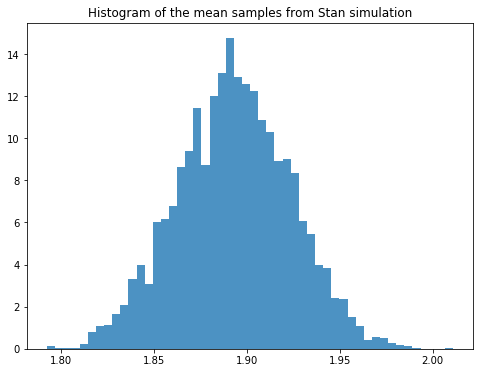


95% CI for the variance: [0.43855944 0.55861454] 
Mean: 0.4959


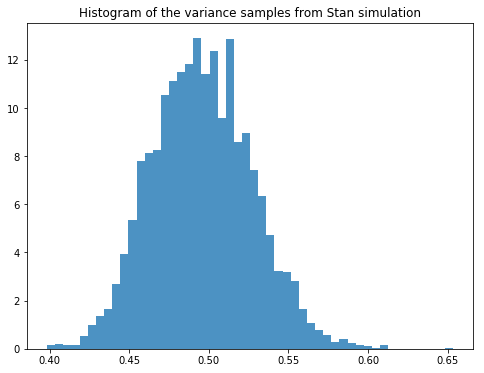

In [27]:
mu_samples = stan_results.extract()['mu_mean']
sigma2_samples = stan_results.extract()['sigma2'] 


# Transfer the parameters of the lognormal
print("95% CI for the mean:",
     np.percentile(mu_samples, [2.5, 97.5]),
     "\nMean:", '{:.4f}'.format(np.mean(mu_samples)))
plt.figure(figsize=(8, 6))
plt.hist(mu_samples, bins=50, density=True, alpha=0.8)
plt.title("Histogram of the mean samples from Stan simulation")
plt.show()


print("\n95% CI for the variance:",
     np.percentile(sigma2_samples, [2.5, 97.5]),
     "\nMean:", '{:.4f}'.format(np.mean(sigma2_samples)))
plt.figure(figsize=(8, 6))
plt.hist(sigma2_samples, bins=50, density=True, alpha=0.8)
plt.title("Histogram of the variance samples from Stan simulation")
plt.show()

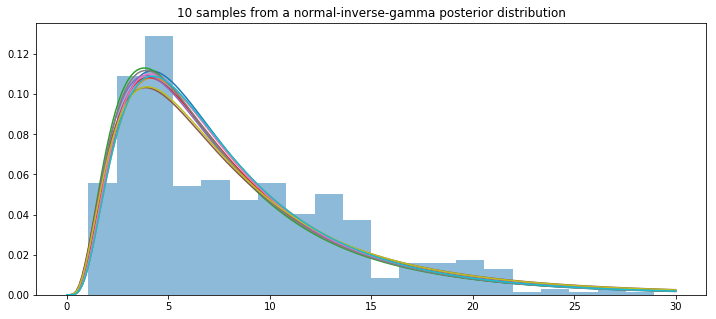

In [31]:
# Generating 10 samples from the Stan results
mean_10 = np.random.choice(mu_samples, 10)
variance_10 = np.random.choice(sigma2_samples, 10)

# Plotting the distributions of the 10 samples
plt.figure(figsize=(12, 5))
plot_x = np.linspace(0, 30, 200)
for i in range(10):
    plot_y = sts.lognorm.pdf(plot_x, np.sqrt(variance_10[i]), 
                             scale=np.exp(mean_10[i]))
    plt.plot(plot_x, plot_y)
plt.hist(np.loadtxt('hrtem.csv'), bins=20, density=True, alpha=0.5)
plt.title('10 samples from a normal-inverse-gamma posterior distribution')
plt.show()

# Appendix:
- confidenceintervals [HC]: Throughout the assignment, we used Stan to construct the confidence interval of the hyperparameters using the sampling method. In other words, confidence interval represents our belief that the parameters of the posterior would fall within a specific range given a certain level (either 95 or 98%)

- simulations [HC]: Stan is using simulation to construct the confidence interval of the posterior parameters as opposed to the method of analytically computing the posterior using Baye's theorem.